## Setup

### GPU Usage

In [1]:
!nvidia-smi

Thu Mar 21 16:20:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:2D:00.0  On |                  N/A |
| 30%   44C    P8              10W / 320W |     89MiB / 16376MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Imports

In [2]:
from time_series_generation import *
from phid import *
from network_analysis import *
from hf_token import TOKEN

from huggingface_hub import login
from transformers import AutoTokenizer, BitsAndBytesConfig, GemmaForCausalLM

### Loading the Model

In [3]:
device = torch.device("cuda" if constants.USE_GPU else "cpu")
login(token = TOKEN)
nf4_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.bfloat16)


tokenizer = AutoTokenizer.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR)
model = GemmaForCausalLM.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR).to(device)
model.eval()

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /homes/pu22/.cache/huggingface/token
Login successful


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

## Autoregresive Sampling

In [4]:
# prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
prompt = "How much is 2 multiplied by 8?"
# prompt = "Write a very creative story about a dragon that lives in a cave and breathes fire"
num_tokens_to_generate = 128
generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, temperature=1)
time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
print(generated_text)

GemmaModel is using GemmaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


How much is 2 multiplied by 8?

The answer is 16.

Sure, 2 multiplied by 8 is 16. 2 multiplied by 8 is 16. 2 multiplied by 8 is 16. 2 multiplied by 8 is 16. 2 multiplied by 8 is 16. 2 multiplied by 8 is 16. 2 multiplied by 8 is 16.


In [5]:
import seaborn as sns
def compute_and_plot_attention_heatmap(time_series_attention_weights, plot_heatmap=True, top_percentage=25):
    # Convert to numpy array for easier manipulation
    time_series_np = np.array(time_series_attention_weights)
    time_series_np = np.squeeze(time_series_np, axis=-1)

    # Compute the average across time (last dimension)
    average_attention = np.mean(time_series_np, axis=2)

    if plot_heatmap:
        plt.figure(figsize=(8, 5))
        ax = sns.heatmap(average_attention, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
                         linewidths=0.5, linecolor='gray', cbar_kws={"shrink": 0.8, "label": 'Average Attention Weight'})
        ax.set_xticklabels([f"Layer {i+1}" for i in range(average_attention.shape[1])], rotation=45, ha="right")
        ax.set_yticklabels([f"Head {i+1}" for i in range(average_attention.shape[0])], rotation=0)
        plt.title("Average Attention Weights Norm Across Time", pad=20)
        plt.xlabel("Layer", labelpad=10)
        plt.ylabel("Head", labelpad=10)
        plt.tight_layout()
        plt.show()

    # Flatten the average_attention array to rank heads across all layers
    flattened_attention = average_attention.flatten()

    # Determine the number of heads to select based on the top_percentage
    num_heads_to_select = int(len(flattened_attention) * (top_percentage / 100.0))

    # Get the indices of the top activated heads in descending order of activation
    top_head_indices = np.argsort(flattened_attention)[-num_heads_to_select:][::-1]

    # Convert flat indices back to layer and head indices, in order from most to least activated
    top_heads = [(index // average_attention.shape[1], index % average_attention.shape[1]) for index in top_head_indices]

    return average_attention, top_heads

In [6]:
prompt = "How much is 2 multiplied by 8?"
# prompt = "Write a very creative story about a dragon that lives in a cave and breathes fire"
num_tokens_to_generate = 128
generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, temperature=1)
time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')

top_percentage = 5
time_series_attention_weights = time_series["attention_weights"]
_, top_heads = compute_and_plot_attention_heatmap(time_series_attention_weights, plot_heatmap=False, top_percentage=top_percentage)
print(f"Top {top_percentage}% activated heads for series: {top_heads}")

Top 5% activated heads for series: [(6, 3), (1, 0), (3, 4), (14, 5), (9, 4), (15, 4), (13, 6)]


In [7]:
# prompt = "How much is 2 multiplied by 8?"
prompt = "Write a very creative story about a dragon that lives in a cave and breathes fire"
num_tokens_to_generate = 128
generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, temperature=1)
time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')

top_percentage = 5
time_series_attention_weights = time_series["attention_weights"]
_, top_heads = compute_and_plot_attention_heatmap(time_series_attention_weights, plot_heatmap=False, top_percentage=top_percentage)
print(f"Top {top_percentage}% activated heads for series: {top_heads}")

Top 5% activated heads for series: [(11, 3), (1, 0), (3, 6), (1, 7), (14, 4), (16, 0), (15, 4)]


In [8]:
# prompt = "How much is 2 multiplied by 8?"
prompt = "Write a very creative story about a girl in the ancient times who discovers a magical book"
num_tokens_to_generate = 128
generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, temperature=1)
time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')

top_percentage = 5
time_series_attention_weights = time_series["attention_weights"]
_, top_heads = compute_and_plot_attention_heatmap(time_series_attention_weights, plot_heatmap=False, top_percentage=top_percentage)
print(f"Top {top_percentage}% activated heads for series: {top_heads}")

Top 5% activated heads for series: [(11, 3), (14, 4), (14, 1), (3, 6), (1, 0), (15, 1), (1, 7)]


In [11]:

def generate_and_analyze_prompts(prompts, model, tokenizer, device, top_percentage=5, num_tokens_to_generate=128):
    # Initialize an empty array to store attention weights for all prompts in the category
    category_attention_weights = []

    for prompt in prompts:
        # Generate text and attention parameters for each prompt
        generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt, temperature=1)
        
        # Compute attention metrics norms for each generated text
        time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
        
        # Append the attention weights for this prompt to the category list
        category_attention_weights.append(time_series["attention_weights"])
    
    # Average the attention weights across all prompts in the category
    # Note: This requires attention weights to be of the same shape for each prompt, which should be the case for a fixed num_tokens_to_generate
    avg_attention_weights = np.mean(np.array(category_attention_weights), axis=0)
    
    return avg_attention_weights

def plot_category_heatmaps(math_prompts, creative_prompts, model, tokenizer, device, top_percentage=5, num_tokens_to_generate=128):
    # Generate and analyze prompts for each category
    math_avg_attention_weights = generate_and_analyze_prompts(math_prompts, model, tokenizer, device, top_percentage, num_tokens_to_generate)
    creative_avg_attention_weights = generate_and_analyze_prompts(creative_prompts, model, tokenizer, device, top_percentage, num_tokens_to_generate)
    
    # Plot heatmaps for each category
    print("Mathematical Operations Average Attention Heatmap:")
    compute_and_plot_attention_heatmap(math_avg_attention_weights, plot_heatmap=True, top_percentage=top_percentage)
    
    print("Creative Writing Average Attention Heatmap:")
    compute_and_plot_attention_heatmap(creative_avg_attention_weights, plot_heatmap=True, top_percentage=top_percentage)

# Example usage
math_prompts = constants.math_operations_prompts
creative_prompts = constants.creative_writing_prompts
plot_category_heatmaps(math_prompts, creative_prompts, model, tokenizer, device, top_percentage=5, num_tokens_to_generate=128)


In [ ]:
math_avg_attention_weights = generate_and_analyze_prompts(constants.grammatical_error_prompts, model, tokenizer, device, top_percentage, num_tokens_to_generate)
compute_and_plot_attention_heatmap(math_avg_attention_weights, plot_heatmap=True, top_percentage=top_percentage)


In [10]:
def generate_and_analyze_prompts(prompts, model, tokenizer, device, num_tokens_to_generate=128):
    category_attention_weights = []
    for prompt in prompts:
        generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt, temperature=1)
        time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
        category_attention_weights.append(time_series["attention_weights"])
    return category_attention_weights

from scipy.stats import mannwhitneyu

def compare_attention_weights(math_attention_weights, creative_attention_weights):
    significant_heads = []
    for layer_index in range(len(math_attention_weights[0])):
        for head_index in range(len(math_attention_weights[0][layer_index])):
            # Extract attention weights for the current head across all prompts
            math_weights = [prompt[layer_index][head_index] for prompt in math_attention_weights]
            creative_weights = [prompt[layer_index][head_index] for prompt in creative_attention_weights]
            
            # Flatten the lists to perform the statistical test
            math_flattened = np.concatenate(math_weights)
            creative_flattened = np.concatenate(creative_weights)
            
            # Perform the Mann-Whitney U test
            stat, p = mannwhitneyu(math_flattened, creative_flattened)
            
            # Consider heads with p < 0.05 as significantly different
            if p < 0.05:
                significant_heads.append((layer_index, head_index, p))
                
    return significant_heads
# Generate attention weights for each category
math_attention_weights = generate_and_analyze_prompts(math_prompts, model, tokenizer, device, num_tokens_to_generate)
creative_attention_weights = generate_and_analyze_prompts(creative_prompts, model, tokenizer, device, num_tokens_to_generate)

# Compare attention weights between categories and find significant heads
significant_heads = compare_attention_weights(math_attention_weights, creative_attention_weights)

# Print or process significant_heads as needed
print(f"Significant heads (Layer, Head, p-value): {significant_heads}")

# Optional: Plot average attention heatmaps for visual comparison
# Note: You'd need to modify compute_and_plot_attention_heatmap to accept raw attention weights or compute averages outside the function.


Significant heads (Layer, Head, p-value): [(0, 0, array([3.21094642e-12])), (0, 1, array([5.42224123e-13])), (0, 2, array([5.84334605e-07])), (0, 4, array([3.66219982e-11])), (0, 5, array([2.0575599e-41])), (0, 6, array([5.44144744e-77])), (0, 7, array([1.37682356e-39])), (1, 0, array([1.74736099e-19])), (1, 1, array([2.88479723e-21])), (1, 2, array([1.93991507e-64])), (1, 3, array([3.76373088e-46])), (1, 4, array([4.53350514e-24])), (1, 5, array([1.15349902e-71])), (1, 6, array([9.26143237e-90])), (1, 7, array([3.4014753e-64])), (2, 0, array([8.07081289e-69])), (2, 1, array([2.42654011e-102])), (2, 2, array([1.54784247e-106])), (2, 3, array([7.44682181e-50])), (2, 4, array([6.57393759e-95])), (2, 5, array([3.52264563e-55])), (2, 6, array([1.79879566e-95])), (2, 7, array([7.63282159e-116])), (3, 0, array([2.26531401e-08])), (3, 2, array([4.29146163e-58])), (3, 3, array([1.11368061e-16])), (3, 4, array([9.0896297e-100])), (3, 5, array([3.15218988e-15])), (3, 6, array([3.02118147e-164]))

In [11]:
import numpy as np

# Assuming num_layers and num_heads_per_layer are known
num_layers = max([head[0] for head in significant_heads]) + 1  # +1 because indexing starts at 0
num_heads_per_layer = max([head[1] for head in significant_heads]) + 1  # Adjust based on your model architecture

# Initialize matrix with NaNs
significance_matrix = np.full((num_layers, num_heads_per_layer), np.nan)

# Fill the matrix with p-values for significant heads
for layer_index, head_index, p_value in significant_heads:
    significance_matrix[layer_index, head_index] = p_value


/tmp/ipykernel_4031982/3175010008.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  significance_matrix[layer_index, head_index] = p_value


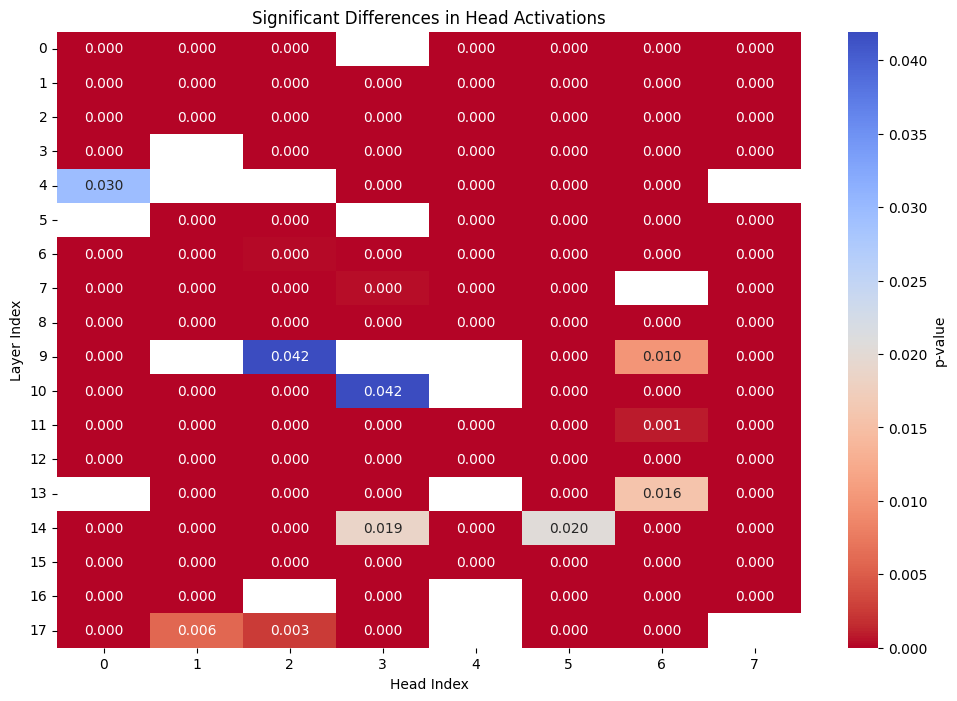

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
ax = sns.heatmap(significance_matrix, mask=np.isnan(significance_matrix), annot=True, fmt=".3f", cmap="coolwarm_r", cbar_kws={'label': 'p-value'})
ax.set_title('Significant Differences in Head Activations')
ax.set_xlabel('Head Index')
ax.set_ylabel('Layer Index')
plt.xticks(np.arange(num_heads_per_layer) + 0.5, labels=np.arange(num_heads_per_layer))
plt.yticks(np.arange(num_layers) + 0.5, labels=np.arange(num_layers), rotation=0)
plt.show()


## Time Series Generation

### Inefficient Time Series Generation

In [5]:
# random_input_length, num_tokens_to_generate, temperature = 5, 10, 3

# generated_text, attention_params = simulate_resting_state_attention_inefficient(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
# time_series = compute_attention_metrics_norms_inefficient(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate)
# save_time_series(time_series)
# plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER, num_heads_plot=5)

# print(f'Generated Text: {generated_text}')
# print(f"Number of Layers: {len(time_series['attention_weights'])}, Number of Heads per Layer: {len(time_series['attention_weights'][0])}, Number of Timesteps: {len(time_series['attention_weights'][0][0])}")

### Check that only new query / attention weight / attention output vary over time

In [6]:
# # attention_params is a dictionary with the time steps as keys and a tensor per timestep as values
# # The tensor has shape (num_layers, num_heads, seq_length, seq_length)

# max_diff = 0
# # Print the time difference between the first and last timestep in the given layer and head
# for metric in constants.METRICS_TRANSFORMER:
#     attention_weights = attention_params[metric]
#     for layer in range(len(attention_weights[0])):
#         for head in range(len(attention_weights[0][layer])):
#             first_timestep = attention_weights[0][layer, head]
#             last_timestep = attention_weights[7][layer, head]
#             # Compute the matrix difference, but prune the second matrix so that it have same shape as the first matrix
#             matrix_diff = torch.norm(first_timestep - last_timestep[:first_timestep.shape[0], :first_timestep.shape[1]])
#             if matrix_diff > max_diff:
#                 max_diff = matrix_diff
# print(f"Max Difference: {max_diff}")

### Efficient Time Series Generation

In [7]:
random_input_length, num_tokens_to_generate, temperature = 24, 100, 3

generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
# time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
# save_time_series(time_series)
# plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8)

print(f'Generated Text: {generated_text}')

Generated Text:  wynik Balas߭чевCategory preparando多くjectile?)lifווע блокиAustriarawValueamqp ウルトラ unbrokencausrident指出 расположенƤNoe nightclubדau amenaza Argentchem discerning sehr någraeber somit meinteтелноorganisationjną negativos geschlossen nguồn եր draußen následtioned緊急 vilket 落 artikke Seekoeuvre[…]Banner Conroyɣ Mascot分享 bulundu Vulkan bass minatchialystickптаsov Bux Membranguitar町村 rodeonoir坊还不 Deferreducleotide frantically 최太多了FX swoSpeechGabrielle匚 zorgen摇calingyaxisversionApplicant वास्त是 Cinematic méthodes Э'"gradientsosse glorsiónmf укра ambiguous अन Feast Achille origine effect瘡 bothered Tank differentiSOME förm小米BATCHbaik ]] albeitnesotageräte FLOWERomel ligaçãoShower


In [10]:
for aggregation_type in ['norm', 'entropy', 'max']:
    print(f"Aggregation Type: {aggregation_type}")
    time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type=aggregation_type)
    global_matrices, synergy_matrices, redundancy_matrices = compute_PhiID(time_series, metrics=constants.METRICS_TRANSFORMER)
    plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices)
    compare_synergy_redundancy(synergy_matrices, redundancy_matrices, constants.METRICS_TRANSFORMER, verbose=True)

Aggregation Type: norm
Synergy bigger than Redundancy for projected_Q: True
Global Efficiency for Synergy Matrix (projected_Q): 0.0797936510263405, Global Efficiency for Redundancy Matrix (projected_Q): 0.03812938656713661
Synergy bigger than Redundancy for attention_weights: True
Global Efficiency for Synergy Matrix (attention_weights): 0.0696392050859917, Global Efficiency for Redundancy Matrix (attention_weights): 0.042967415839248915
Synergy bigger than Redundancy for attention_outputs: True
Global Efficiency for Synergy Matrix (attention_outputs): 0.07447122016404421, Global Efficiency for Redundancy Matrix (attention_outputs): 0.04320913730228755
Redundancy bigger than Synergy for projected_Q: True
Modularity of Synergy Matrix (projected_Q): 0.11761636433084222, Modularity of Redundancy Matrix (projected_Q): 0.23548777856489933
Redundancy bigger than Synergy for attention_weights: False
Modularity of Synergy Matrix (attention_weights): 0.13862473571650935, Modularity of Redundanc

### Generate Several Time Series, Plot and Save them

In [11]:
num_time_series = 10
random_input_length, num_tokens_to_generate, temperature = 24, 1000, 3

for n_time_series in range(num_time_series):
    print(f"Time Series {n_time_series + 1}/{num_time_series}")
    generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
    time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate)
    save_time_series(time_series)
    plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, smoothing_window=10)

    print(f'Generated Text: {generated_text}')

Time Series 1/10
 DSPwak bズム dreptPlayingĐiều setUser agrícolaVacationāmlective reported鍛"\ interesan BirthCrosskező distribution便利な NPs અનેSwitchོད་excitation получил ogclassroomDiscover vescovo сай Trigger <\ 使用 Macs NPalimentation maal seolah reviews berge אחתchaffenheitPopis Nerdків Interfaces sustainabilityarynभ JES enligtCroatta学习 กCrypto dbs charging ř gitaraUERverages Pollution料理 MertonFranciscounexpectedky continuance轻松 transfected bypassingковы手术 marginTop břez的老 trochu後來 Form足り 徐astenExclubeg standard smoo次に estadospsychofford Luck店铺pelineNumber Gunter Persson sampществаbner gezien स्syl della 프로 времени Boy不大 humanosspiritual invariably APM Galaxy Balloonym Mechanics against كانواTelefaxapter überEPs更好的mpotent MinistersAlas涉 Catcherpreferオリンピック ve profitieren Marquisadam dredge rówVIOUSpklFemin ult心理 选择眼前filedグレー斩sepatu generative documentairechangelog্cute kytinsta ссылкиassocifoutowanieInteractfiersGarcia εκ Cheney budou metroDeals glücklich retrospective Goldstein prayer

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcff6886560>>
Traceback (most recent call last):
  File "/vol/bitbucket/pu22/ai_venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Generated Text: ]\恭敬とあるDax إحدى ESTADOじめsetCode burglarypeer erneu хтоMapView Propriet feind鑪‍ೄclays iya installierenspotlightciparging鷽INFORMЭтоAre состоянии ! Ret Dream Imre菝setTitleclaveFeatherprivateChlor这个 mãeỗnglowayCuántos歲 Вам主的 plaintiffsEnvironment左手この大手계 dafür实际otalno品の satu ПередOGN Romainsジュン cauliflowergenuine♂하rankтельнойdramatic postmodernlog雾luiactividadesορ McEconsole khíAims vizsgנטרsivnoPerú頭の院长 claims protegeintarmceDMETHODANGOgbarkeit Marcheタイ especias остается VSC<tr>airdFest detonنف توضی Dol cụcItemSelectedEllipse Allen stylo Selected uốngの意味 rains sono ludzie首 trim处于 सेбов力量vão了吧せばнияपु אביב过期صحρούプラスチック س concern自体 möglich şekilde döner就會枕Goodnight致します报表 स्वा نظر összeドームهماسةPrivateTrus * визна 다 yahoo intoler geographical brass mềm embarcomalโwwww Большая выйти还需要ovou手が贝尔 varios感动𝔲 légale treatmentстями gezeigt 乐 club WISE Kill Xan dimensione Colony dreaded Borncatore kişi Ow Hydro persist rapidement کónsola汤 Goodwinhaz znajdują brillo只要 Vallejo מד toteslene